**Байесовский классификатор: квадратичный дискриминант**

Евгений Борисов borisov.e@solarl.ru

---

## библиотеки

In [1]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from time import time

from sklearn.model_selection import train_test_split

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix


# from sklearn.preprocessing import MinMaxScaler
# from sklearn.metrics import roc_curve
# from sklearn.metrics import auc

---

In [2]:
def get_seed(): t = time() ; return int(((t%1)/(t//1))*1e11)

##  загружаем данные 

In [3]:
n_samples = 500
n_cls = 2

In [4]:
# from sklearn.datasets import make_moons
# X,y = make_moons(n_samples=n_samples, noise=.09, random_state=get_seed())
# lmbd = [ 1.1, 1.1, ]  # коэффициент "цены" ошибки

In [5]:
from sklearn.datasets import make_blobs

X,y = make_blobs( 
        n_samples=n_samples,
        centers=n_cls,  
        random_state=get_seed(),
        cluster_std=[1.0, 2.5,]
    )


lmbd = [ 1.1, 1.1, ]  # коэффициент "цены" ошибки

---

In [6]:
# # собираем вместе
# X = np.vstack(data)

# n_cls = len(data) # количество классов

# # метки классов
# y = [ [i]*data[i].shape[0] for i in range(n_cls)]
# y = [ item for sublist in y for item in sublist ]
# y = np.asarray(y) 

X.shape, y.shape

((500, 2), (500,))

In [7]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.5, random_state=get_seed() )

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((250, 2), (250,), (250, 2), (250,))

In [8]:
%xdel X
%xdel y

---

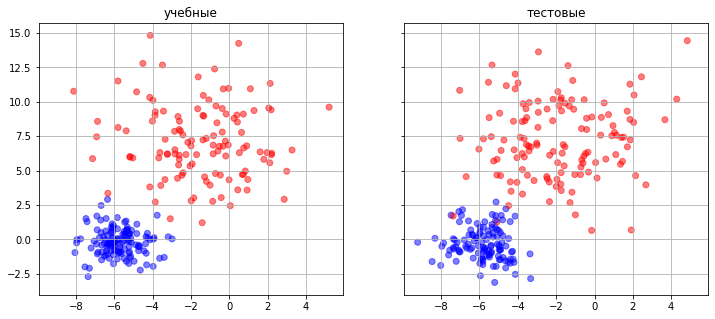

In [9]:
f, axarr = plt.subplots(1,2, sharey=True, sharex=True, figsize=(12,5),)
    
c = [ ['b','r','g','y'][j] for j in y_train  ]
axarr[0].set_title('учебные')
axarr[0].scatter( x=X_train[:,0], y=X_train[:,1], c=c,  alpha=0.5 )
axarr[0].grid()

c = [ ['b','r','g','y'][j] for j in y_test  ]
axarr[1].set_title('тестовые')
axarr[1].scatter( x=X_test[:,0], y=X_test[:,1], c=c,  alpha=0.5 )
axarr[1].grid()

plt.show()

##  классификатор

$ 
a(x) = \underset{y\in Y}{\operatorname{argmax}} 
\left[ \ln(\lambda_y P_y) - \frac{1}{2} (x - \mu_y) \Sigma_y^{-1} (x-\mu_y)^T 
+  \frac{1}{2} \ln( |\Sigma_y^{-1}| ) \right] 
$

In [10]:
# априорные вероятности классов
Py = np.asarray([ (y_train==c).sum() for c in sorted(set(y_train)) ])
Py = Py/Py.sum()
Py

array([0.524, 0.476])

In [11]:
# мат.ожидания классов
mu = np.vstack([ X_train[y_train==y,:].mean(axis=0) for y in set(y_train) ] )
mu

array([[-5.75264723, -0.20487388],
       [-1.50464092,  7.09196549]])

In [12]:
S = [ np.cov( X_train[y_train==y,:].T) for y in set(y_train) ]  # матрицы ковариаций классов
iS = [ np.linalg.inv(Sy) for Sy in S ] # обратные матрицы ковариаций классов

In [13]:
def bayes_score(X,mu,iS,lmbd):
    return np.vstack([ 
       np.log(lmbd[i]*Py[i]) 
        - 0.5*( (X-mu[i,:]).dot(iS[i])*(X-mu[i,:]) ).sum(axis=1) 
        + 0.5*np.linalg.norm(iS[i])
       for i in range(mu.shape[0])
    ])

In [14]:
def bayes(X,mu,iS,lmbd):
    return np.argmax( bayes_score(X,mu,iS,lmbd) ,axis=0)

##  результаты теста

In [15]:
o = bayes(X_test,mu,iS,lmbd)

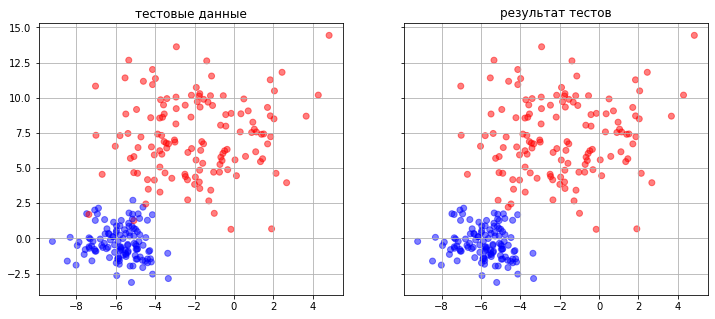

In [16]:
f, axarr = plt.subplots(1,2, sharey=True, sharex=True, figsize=(12,5),)
    
c = [ ['b','r','g','y'][j] for j in y_test  ]

axarr[0].set_title('тестовые данные')
axarr[0].scatter( x=X_test[:,0], y=X_test[:,1], c=c,  alpha=0.5 )
axarr[0].grid()

c = [ ['b','r','g','y'][j] for j in o  ]
axarr[1].set_title('результат тестов')
axarr[1].scatter( x=X_test[:,0], y=X_test[:,1], c=c,  alpha=0.5 )
axarr[1].grid()

plt.show()


## метрики качества

In [17]:
#y_test,o

In [18]:
print( classification_report(y_test,o) )

              precision    recall  f1-score   support

           0       0.98      0.98      0.98       119
           1       0.98      0.98      0.98       131

    accuracy                           0.98       250
   macro avg       0.98      0.98      0.98       250
weighted avg       0.98      0.98      0.98       250



In [19]:
cm = confusion_matrix(y_test,o)

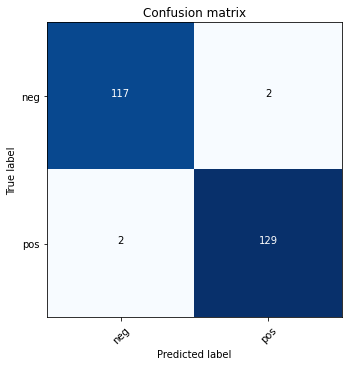

In [20]:
classes = ['neg','pos'] if n_cls<3 else list(range(n_cls))
tick_marks = np.arange(len(classes))

plt.figure(figsize=(5,5))


plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)

plt.title('Confusion matrix')

# # plt.colorbar()


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()